# 多分类问题
使用对率回归模型解决多分类问题
1. one-VS-rest(OvR)
    假设有K个类别，则需要训练K个二分类器，例如针对第k个类别的训练，则把其他类均视为负类
2. one-VS-one(OvO)
    把每一个类拿出来，两两配对，需要训练$\frac{(K-1)K}{2}$个二分类器

* 实验数据是5000张20$\times$20的灰度图像，则每一张图像是一个400维的向量，也即特征数量是400个，数据集包含5000个样本。灰度图像是手写数字，也即一个10个类别（从0到9）。
* 数据存放在.mat文件也即matlab本地文件格式，需要使用scipy包，另外可以将向量转为图像看一下

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat

In [3]:
data = loadmat('ex3data1.mat')
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'y': array([[10],
        [10],
        [10],
        ...,
        [ 9],
        [ 9],
        [ 9]], dtype=uint8)}

In [4]:
type(data)

dict

In [5]:
X = data['X']
y = data['y']
X.shape, y.shape

((5000, 400), (5000, 1))

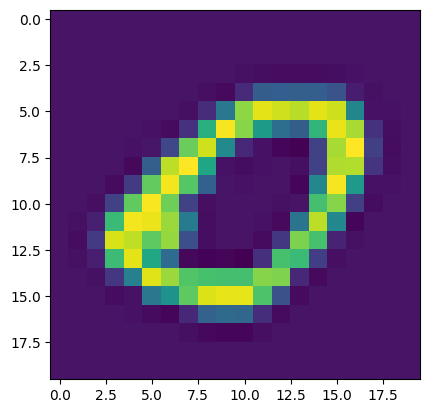

In [9]:
# 将X[0]转为灰度图进行查看
img = np.reshape(X[0, :], (20, 20))
plt.imshow(img)

In [14]:
# one-vs-rest, X本身是需要插入1的这不会变, 但y需要变一下
K = 10 # 输出类别数目
m = len(y) # 数据集大小
n = X.shape[1] # 特征的数目
X = np.matrix(np.insert(X, 0, 1, axis=1)) # 这种insert可以反复多次, 因此注意仅执行一次
# X = np.delete(X, 0, axis=1)
X.shape

(5000, 401)

In [32]:
Y = np.matrix(np.zeros((m, K)))
Y[:, 0] = np.matrix([1 if int(i)==10 else 0 for i in y]).T
np.sum(Y[:, 0]) # 可见一共有500个0

500.0

In [37]:
# 接下来是1到9
for i in range(1, K):
    Y[:, i] = np.matrix([1 if int(j)==i else 0 for j in y]).T
# np.sum(Y[:, i]) == 500 (for i=0 to 9)

In [44]:
# 书写函数
# sigmoid
def sigmoid(z):
    return 1/(1+np.exp(-z))
theta = np.matrix(np.zeros((K, X.shape[1])))
X.shape, Y.shape, theta.shape

((5000, 401), (5000, 10), (10, 401))

In [64]:
# costFunc
def costFunc(theta, X, y, _lambda):
    theta = np.matrix(theta)
    h_x = sigmoid(X*theta.T)
    normal = (1/m)*float(-y.T*np.log(h_x)-(1-y.T)*np.log(1-h_x))
    reg = (_lambda/2*m)*float(theta*theta.T)
    return normal+reg
costFunc(theta[0, :], X, Y[:, 0], 1)

0.693147180559947

In [65]:
def gradient(theta, X, y, _lambda):
    theta = np.matrix(theta)
    h_x = sigmoid(X*theta.T)
    err = h_x-y
    d_reg = _lambda*theta.T
    d_reg[0]=0
    return (X.T*err+d_reg).T/m
# t_theta = np.matrix(np.ones(X.shape[1]))
# gradient(t_theta, X, Y[:, 0], 0.8)

In [71]:
from scipy import optimize as opt
def train(X, Y, theta, _lambda):
    res = []
    for i in range(K):
        thetai = theta[i, :]
        yi = Y[:, i]
        res.append(opt.fmin_tnc(
            func=costFunc, 
            fprime=gradient, 
            x0=thetai, 
            args=(X, yi, _lambda)
        ))
    return res

In [75]:
# 初始化参数开始训练
_lambda = 1
result = train(X, Y, theta, _lambda)

In [80]:
# 得到10个分类器
np.matrix(result[0][0]).shape

(1, 401)

In [105]:
# 一个判断20X20灰度图像数字的分类器
def digit_classifier(img_arr, result):
    img_arr = np.matrix(np.reshape(img_arr, (1, 400)))
    img_arr = np.insert(img_arr, 0, 1, axis=1)
    prd = []
    for i in range(K):
        theta = np.matrix(result[i][0])
        prd.append(float(sigmoid(img_arr*theta.T)))
    return prd.index(max(prd))

In [84]:
# 将result存起来
store_res = {}
for i in range(K):
    store_res['theta'+str(i)]=result[i][0].tolist()
pd.DataFrame(store_res).to_csv('theta_OvR.csv', index=False)

In [106]:
# 尝试一些图案
tk = 4700
img1 = X[tk, 1:] 
digit_classifier(img1, result)

9

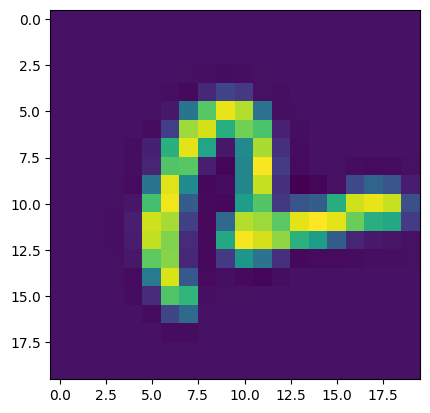

In [104]:
plt.imshow(np.reshape(img1, (20, 20)))

In [112]:
# 测了几张，还挺准的哈，看在训练集上的准确率
is_ok = 0
for i in range(m):
    img_arr = X[i, 1:]
    prd = digit_classifier(img_arr, result)
    if(Y[i, prd]==1):
        is_ok = is_ok+1
is_ok

3775

In [113]:
print(str(is_ok*100/m)+"%")

75.5%
